In [1]:
import sys
import os
from sklearn.datasets import fetch_20newsgroups
from keras.layers import  Dropout, Dense, Flatten, RepeatVector, Conv2D
from keras.models import Sequential, model_from_json
from keras.utils.vis_utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
import pandas as pd
from data_preprocessing import DataPreprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pydot
import csv
from sklearn.metrics.pairwise import cosine_similarity

Using TensorFlow backend.


# Import DNN

In [3]:
def load_model(json_file, h5_file):
    json_file = open(json_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(h5_file)
    print("Loaded model from disk")
    return loaded_model

x_train = pd.read_csv('6_new_test_train_dataset/x_test.csv')['review']
x_test = pd.read_csv('6_new_test_train_dataset/x_train.csv')['review']
loaded_model = load_model("model_DNN_4_layers.json", "model_DNN_4_layers.h5")


Loaded model from disk


In [4]:
def TFIDF(X_train, X_test,MAX_NB_WORDS=75000):
    vectorizer_x = TfidfVectorizer(max_features=MAX_NB_WORDS)
    X_train = vectorizer_x.fit_transform(X_train).toarray()
    X_test = vectorizer_x.transform(X_test).toarray()
    return (X_train,X_test)



In [6]:
genre_list = [
        'Action',
        'Adventure',
        'Animation',
        'Biography',
        'Comedy',
        'Crime',
        'Drama',
        'Fantasy',
        'History',
        'Horror',
        'Music',
        'Mystery',
        'Romance',
        'Sci-Fi',
        'Sport',
        'Thriller',
        'War'
    ]


[[23.  6.  1.  0. 12.  7.  1. 19.  0. 13.  0.  5.  0.  4.  0.  8.  0.]]


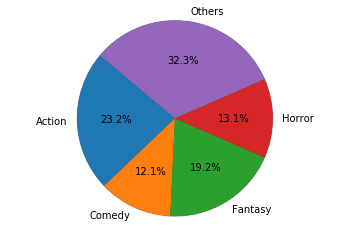

In [7]:
movie_name = "green_lantern"
test_review = ""

with open(f"DNN_input_files/input2-{movie_name}.txt", "r") as fi:
    test_review = fi.read()
    
test_review = DataPreprocessing(test_review).preprocess()

train_review, test_review = TFIDF(x_train,[test_review])
predicted = loaded_model.predict(test_review)
predicted1 = (predicted)
sum=0
for num in predicted1[0]:
    sum += num

print(np.round(predicted1*100.0/sum))
pred = np.round(predicted1*100.0/sum)
def pieplot(x_data, y_label) :
#     explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    data = list(zip(x_data, y_label))

    exploded = []
    y_label_1 = []
    gt_10_values = []
    gt_10_genres = []
    others = 0
    for i, percent in enumerate(x_data):
        if percent >= 10:
            gt_10_values.append(percent)
            gt_10_genres.append(y_label[i])
        else:
            others += percent
    gt_10_values.append(others)
    gt_10_genres.append("Others")
#     top_3_tuples = data[0:3]
    fig1, ax1 = plt.subplots()
    
    ax1.pie(gt_10_values, labels=gt_10_genres, autopct='%1.1f%%', radius=2000,
            shadow=True, startangle=140)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    
pieplot(pred[0], genre_list)

In [16]:
def recommend_movies_by_genres(genres=[], num_movies=10):
    df = pd.read_csv("6_recommendation/movies.csv")
    input_genresi=genres
    list_of_cos_sim = []
    for idx,row in df.iterrows():
        row1 = row[1:]
#         print(row1)
        try:
            rowi = list(map(int, row1))
        except Exception as er:
            continue
        cos_sim = (cosine_similarity([rowi], [input_genresi]))
        list_of_cos_sim.append((cos_sim[0][0],row[0]))
    list_of_cos_sim.sort(reverse=True)
    count = 0
    for value, name in list_of_cos_sim:
        print (name + "\t\t\t\t\t" + str(value))
#         print (df.loc[ df["movie_name"] == movie_name])
        count+=1
        if count >= num_movies:
            break

recommend_movies_by_genres(genres=pred[0], num_movies=10)

10% Files done
20% Files done
30% Files done
40% Files done
50% Files done
60% Files done
70% Files done
80% Files done
90% Files done
100% Files done


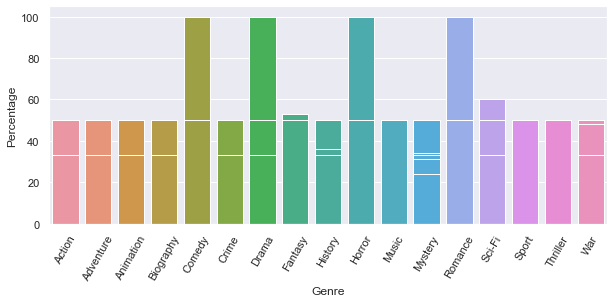

In [8]:
files = os.listdir("3_reviews_per_movie_cleaned")


csv.register_dialect('myDialect',delimiter=',', quoting=csv.QUOTE_ALL,skipinitialspace=True)
with open("6_recommendation/movies.csv", "w") as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['movie_name'] + genre_list)

ctr = 10
ctr1 = 0
for file in files:
    csv_file = pd.read_csv("3_reviews_per_movie_cleaned/" + file)
    test_review = csv_file['review']
    review1 = ""
    for review in test_review:
        review1 += review + " "
    train_review, test_review = TFIDF(x_train,[review1])
    
    
    predicted = loaded_model.predict(test_review)
    predicted1 = (predicted)
    sum=0
    for num in predicted1[0]:
        sum += num
    pred = np.round(predicted1*100.0/sum)
    with open("6_recommendation/movies.csv", "a") as f:
        movie_name = []
        writer = csv.writer(f, dialect='myDialect')
        movie_name.append(file[:-4])
        movie_name.extend(pred[0])
        writer.writerow(movie_name)
    ctr1 += 1
    if ctr == ctr1*100//len(files):
        print(str(ctr) + "% Files done")
        ctr += 10
    top_df = pd.DataFrame(list(zip(genre_list,pred[0])))
    top_df.columns=["Genre", "Percentage"]#Barplot of most freq words
    sns.set(rc={'figure.figsize':(10,4)})
    g = sns.barplot(x="Genre", y="Percentage", data=top_df)
    g.set_xticklabels(g.get_xticklabels(), rotation=60)

In [55]:
def recommend_movies(movie_name="3 Idiots 2009", num_movies=10):
    df = pd.read_csv("6_recommendation/movies.csv")
    input_genres = df.loc[df["movie_name"] == movie_name]
    input_genres1 = []
    
    for genre in genre_list:
        input_genres1.append(input_genres[genre])
    input_genresi = list(map(int, input_genres1))
    list_of_cos_sim = []
    for idx,row in df.iterrows():
        if row[0] == movie_name:
            print("Genres:" + str(row))
            continue
        row1 = row[1:]
        rowi = list(map(int, row1))
        cos_sim = (cosine_similarity([rowi], [input_genresi]))
        list_of_cos_sim.append((cos_sim[0][0],row[0]))
    list_of_cos_sim.sort(reverse=True)
    count = 0
    for value, name in list_of_cos_sim:
        print (name + "\t\t\t\t\t" + str(value))
#         print (df.loc[ df["movie_name"] == movie_name])
        count+=1
        if count >= num_movies:
            break
#     print(input_genres1)
# recommend_movies('The Shining 1980', 10)
# print()
# recommend_movies('Whiplash 2014', 10)
# print()
# recommend_movies('King Kong 1933', 10)
# print()
# recommend_movies('Rocky 1976', 10)
# print()
# recommend_movies('M.S. Dhoni: The Untold Story 2016', 10)
print()
recommend_movies('The Avengers 2012', 10)


Genres:movie_name     The Avengers 2012
Action                        33
Adventure                     33
Animation                      0
Biography                      0
Comedy                         0
Crime                          0
Documentary                    0
Drama                          0
Family                         0
Fantasy                        0
History                        0
Horror                         0
Music                          0
Mystery                        0
Romance                        0
Sci-Fi                        33
Sport                          0
Thriller                       0
War                            0
Western                        0
Name: 6, dtype: object
X-Men: Days of Future Past 2014					1.0
Star Wars: Episode VII - The Force Awakens 2015					1.0
Star Trek 2009					1.0
Serenity 2005					1.0
Rogue One: A Star Wars Story 2016					1.0
Predator 1987					1.0
Mad Max: Fury Road 2015					1.0
Jurassic Park 1993					1.0
Iron Man 200

In [56]:
def get_top_movies_per_genre(num_movies=10):
    df = pd.read_csv("6_recommendation/movies.csv")
    for genre in genre_list:
        df1 = df.sort_values(by=genre, ascending=False)
        count = 0
        print (genre + ": ")
        print()
        for idx,row in df1.iterrows():
            print (row['movie_name'])
            count+=1
            if count >= num_movies:
                break
        print ()

get_top_movies_per_genre()
    